Подгружаю нужные библиотеки


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

Подгружаю и вывожу данные для их проверки

In [31]:
data = pd.read_excel('train.xlsx')

Первым делом разделяю данные на 2 выборки: 1 тренировочная - 80% данных.Вторая тестовая - 20% данных

In [32]:
# Разделение данных на тренировочную (80%) и тестовую (20%) выборки
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Проверка размеров выборок
print(f"Размер тренировочной выборки: {len(train_data)}.")
print(f"Размер тестовой выборки: {len(test_data)}.")

# Сохранение выборок (по желанию)
test_data.to_excel('test_data.xlsx', index=False)
train_data.to_excel('train_data.xlsx', index=False)

print("Данные успешно разделены.")
print(f"Тестовая выборка:\n{test_data}")
print(f"Тренировочная выборка:\n{train_data}")

Размер тренировочной выборки: 320.
Размер тестовой выборки: 80.
Данные успешно разделены.
Тестовая выборка:
            dt  Цена на арматуру
320 2021-02-22             48500
321 2021-03-01             48000
322 2021-03-08             49000
323 2021-03-15             50500
324 2021-03-22             50800
..         ...               ...
395 2022-08-01             47500
396 2022-08-08             49000
397 2022-08-15             47500
398 2022-08-22             46500
399 2022-08-29             46000

[80 rows x 2 columns]
Тренировочная выборка:
            dt  Цена на арматуру
0   2015-01-05             32900
1   2015-01-12             32500
2   2015-01-19             32000
3   2015-01-26             30700
4   2015-02-02             30300
..         ...               ...
315 2021-01-18             62000
316 2021-01-25             62000
317 2021-02-01             59000
318 2021-02-08             55000
319 2021-02-15             51500

[320 rows x 2 columns]


Преобразование дат и предобработка, Удаляю пропуски из данных с помощью dropna,Создаю индикатор времени.

In [33]:
train_data['dt'] = pd.to_datetime(train_data['dt'])
test_data['dt'] = pd.to_datetime(test_data['dt'])

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

train_data['День'] = (train_data['dt'] - train_data['dt'].min()).dt.days

Создаём признаки и целевую переменную

In [34]:
X_train = train_data[['День']]
y_train = train_data['Цена на арматуру']

Начинаю создавать модель

In [35]:
model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=5, silent=True)
model.fit(X_train, y_train)

Создаю будующие понедельники и предсказания (10 недель вперёд).Создаю DataFrame для будующих дней.Делаю предсказания для будующих понедельников. Ну и на конец создаю DataFrame с будующими датами и предсказаниями

In [36]:
future_weeks = 10  # 10 недель
last_day = train_data['День'].max()  
future_dates = pd.date_range(start=train_data['dt'].max() + pd.Timedelta(days=7), periods=future_weeks, freq='W-MON')

future_days_index = np.arange(last_day + 1, last_day + future_weeks + 1).reshape(-1, 1)

future_predictions = model.predict(future_days_index)

print(f"Длина future_dates: {len(future_dates)}")
print(f"Длина future_predictions: {len(future_predictions)}")

future_df = pd.DataFrame({'dt': future_dates, 'Цена на арматуру': future_predictions})

Длина future_dates: 10
Длина future_predictions: 10


Первым делом делаю преобразование дат и очистку данных. Далее создаю дополнительные признаки для 2 выборок. В конце делаю удаление NaNов 

In [37]:
train_data['dt'] = pd.to_datetime(train_data['dt'])
test_data['dt'] = pd.to_datetime(test_data['dt'])

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Создание новых признаков для train_data
train_data['День'] = (train_data['dt'] - train_data['dt'].min()).dt.days
train_data['Месяц'] = train_data['dt'].dt.month
train_data['Год'] = train_data['dt'].dt.year
train_data['ДеньНедели'] = train_data['dt'].dt.dayofweek
train_data['ЦенаL1'] = train_data['Цена на арматуру'].shift(1)  # Лаг 1
train_data['ЦенаL2'] = train_data['Цена на арматуру'].shift(2)  # Лаг 2

# Создание новых признаков для test_data
test_data['День'] = (test_data['dt'] - test_data['dt'].min()).dt.days
test_data['Месяц'] = test_data['dt'].dt.month
test_data['Год'] = test_data['dt'].dt.year
test_data['ДеньНедели'] = test_data['dt'].dt.dayofweek
test_data['ЦенаL1'] = test_data['Цена на арматуру'].shift(1)  # Лаг 1
test_data['ЦенаL2'] = test_data['Цена на арматуру'].shift(2)  # Лаг 2


train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

Начинаю создавать и обучать модель

In [38]:
train_data = pd.read_excel('train.xlsx')

train_data['dt'] = pd.to_datetime(train_data['dt'])

train_data['День'] = train_data['dt'].dt.day
train_data['Месяц'] = train_data['dt'].dt.month
train_data['Год'] = train_data['dt'].dt.year
train_data['ДеньНедели'] = train_data['dt'].dt.dayofweek
train_data['ЦенаL1'] = train_data['Цена на арматуру'].shift(1)
train_data['ЦенаL2'] = train_data['Цена на арматуру'].shift(2)

train_data.dropna(inplace=True)

X_train = train_data[['День', 'Месяц', 'Год', 'ДеньНедели', 'ЦенаL1', 'ЦенаL2']]
y_train = train_data['Цена на арматуру']

model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, silent=True)
model.fit(X_train, y_train)

Модель создана и можно начать прогнозирование будующих значений.Так же заполняю лаговоые значения

In [39]:
future_dates = pd.date_range(start=train_data['dt'].max() + pd.Timedelta(days=1), periods=future_weeks, freq='W-MON')

future_data = pd.DataFrame({
    'День': future_dates.day,
    'Месяц': future_dates.month,
    'Год': future_dates.year,
    'ДеньНедели': future_dates.dayofweek,
})

last_price = train_data['Цена на арматуру'].iloc[-1]  
future_data['ЦенаL1'] = last_price  
future_data['ЦенаL2'] = last_price

future_predictions = model.predict(future_data)
future_df = pd.DataFrame({'dt': future_dates, 'Цена на арматуру': future_predictions})
print(future_df)

          dt  Цена на арматуру
0 2022-09-05      46395.444698
1 2022-09-12      46193.762805
2 2022-09-19      46703.187278
3 2022-09-26      46573.575602
4 2022-10-03      48836.987354
5 2022-10-10      48301.145025
6 2022-10-17      48382.584609
7 2022-10-24      48033.715565
8 2022-10-31      46819.865598
9 2022-11-07      48307.424269


Прогнозирую

In [40]:
future_predictions = model.predict(future_data)

Создаю DataFrame с будующими датами и предсказаниями

In [41]:
future_df = pd.DataFrame({'dt': future_dates, 'Цена на арматуру': future_predictions})
print(future_df)

          dt  Цена на арматуру
0 2022-09-05      46395.444698
1 2022-09-12      46193.762805
2 2022-09-19      46703.187278
3 2022-09-26      46573.575602
4 2022-10-03      48836.987354
5 2022-10-10      48301.145025
6 2022-10-17      48382.584609
7 2022-10-24      48033.715565
8 2022-10-31      46819.865598
9 2022-11-07      48307.424269


In [42]:
X_test = test_data[['День', 'Месяц', 'Год', 'ДеньНедели', 'ЦенаL1', 'ЦенаL2']]
y_test = test_data['Цена на арматуру']

y_pred = model.predict(X_test)

Строю график прогноза цены на арматуру

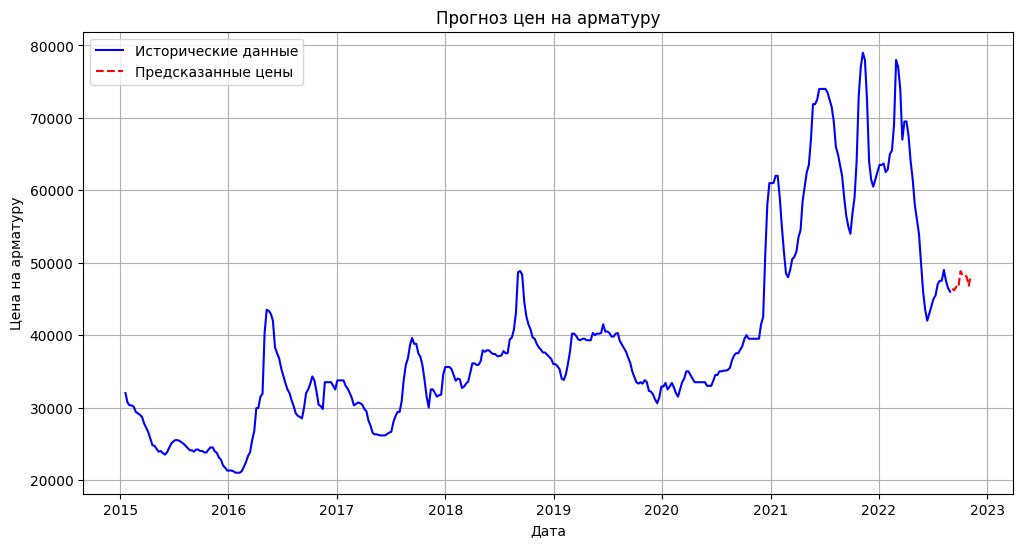

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['dt'], train_data['Цена на арматуру'], label='Исторические данные', color='blue')
plt.plot(future_df['dt'], future_df['Цена на арматуру'], label='Предсказанные цены', color='red', linestyle='--')
plt.title('Прогноз цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.grid()
plt.show()

Делаю вывод 4 графиков: 1 - оригинальный временной ряд, 2 - Тренд, 3 - Сезонность, 4 - Шум

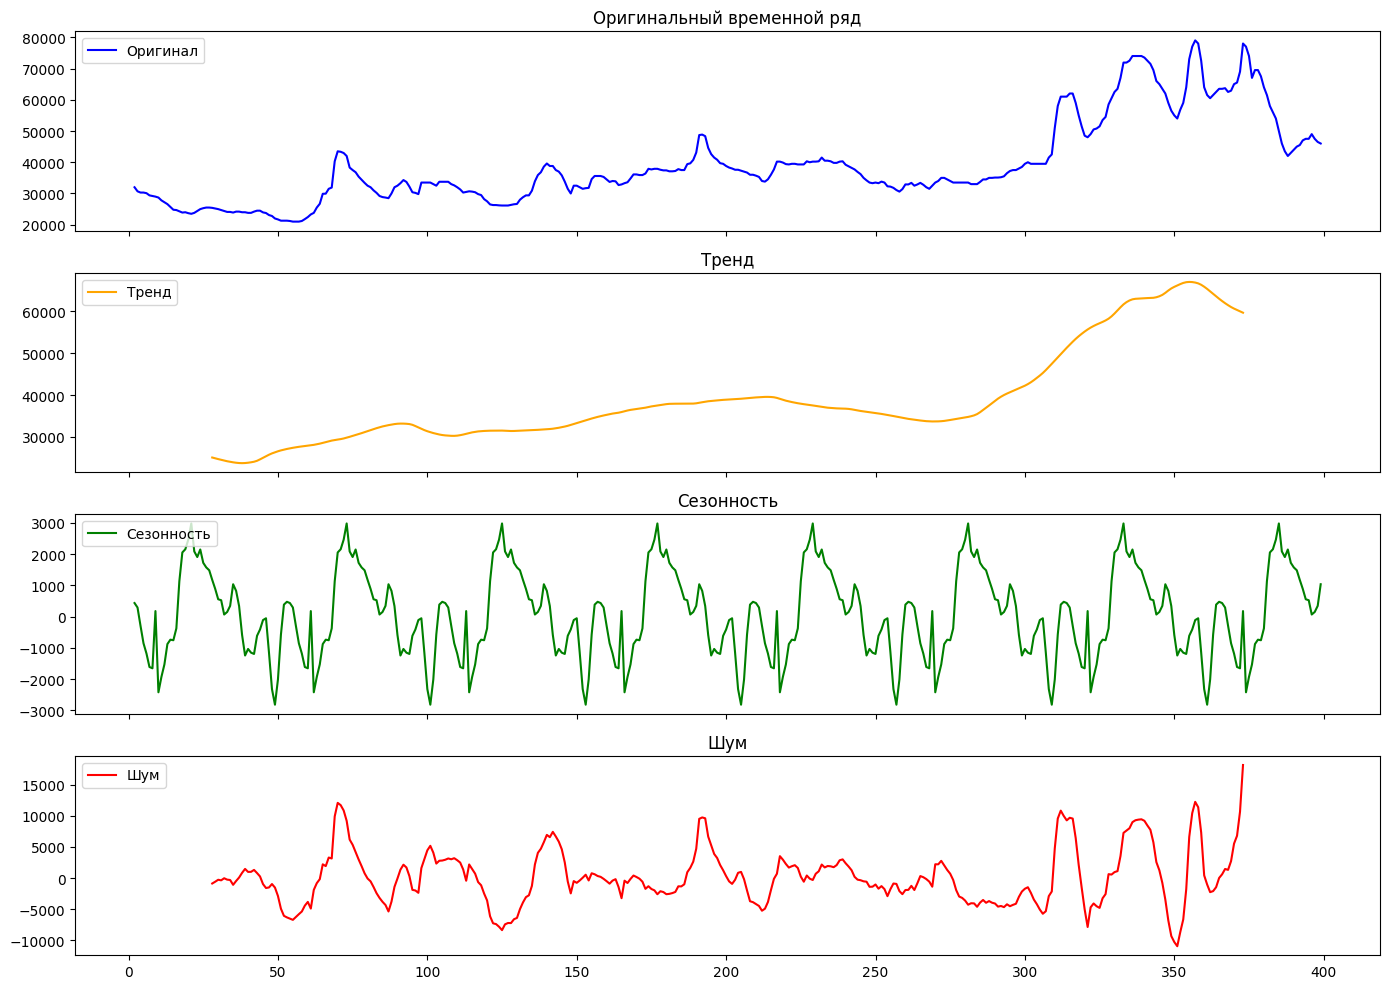

In [ ]:
train_series = train_data['Цена на арматуру']

# Разложение временного ряда на компоненты
result = seasonal_decompose(train_series, model='additive', period=52)  # Параметр 'period' нужно подбирать в зависимости от периодичности ваших данных

# Визуализация компонентов
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# График оригинального временного ряда
ax1.plot(train_series, label='Оригинал', color='blue')
ax1.set_title('Оригинальный временной ряд')
ax1.legend(loc='upper left')

# График тренда
ax2.plot(result.trend, label='Тренд', color='orange')
ax2.set_title('Тренд')
ax2.legend(loc='upper left')

# График сезонности
ax3.plot(result.seasonal, label='Сезонность', color='green')
ax3.set_title('Сезонность')
ax3.legend(loc='upper left')

# График шума
ax4.plot(result.resid, label='Шум', color='red')
ax4.set_title('Шум')
ax4.legend(loc='upper left')

plt.tight_layout()
plt.show()

Строю график сравнения

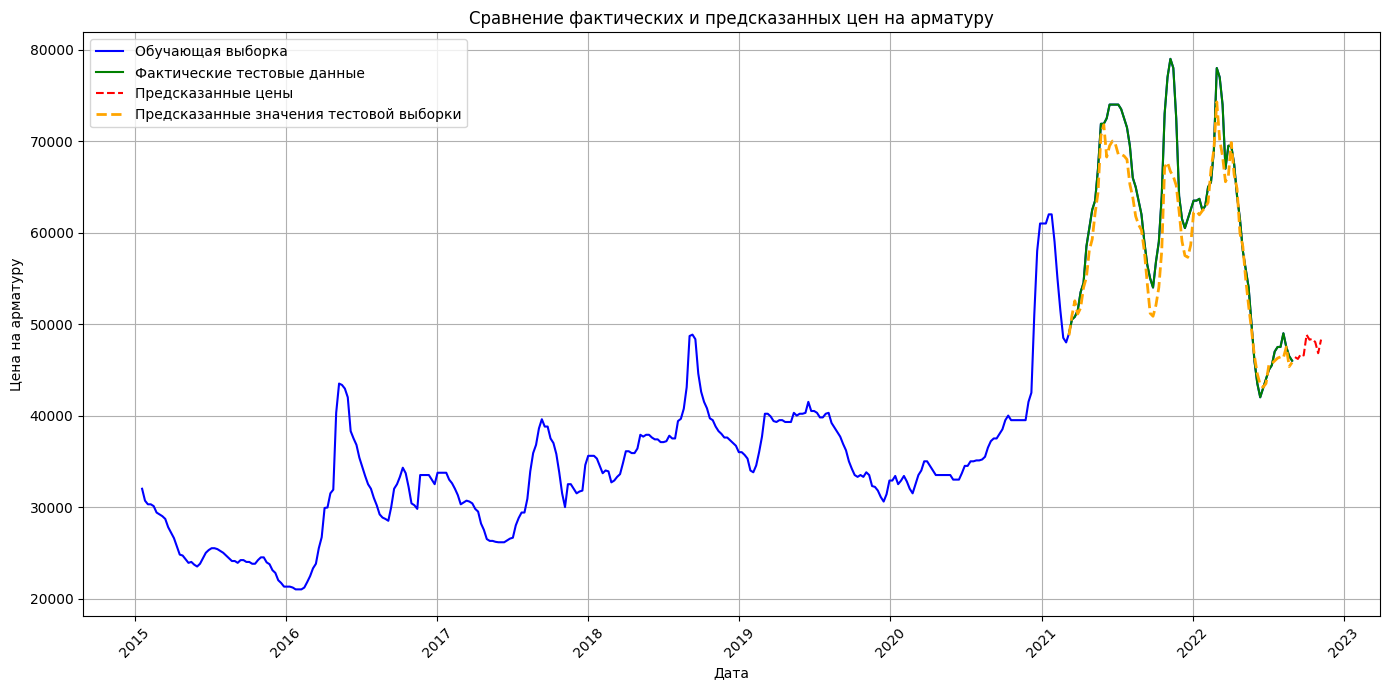

In [17]:
plt.figure(figsize=(14, 7))
plt.plot(train_data['dt'], train_data['Цена на арматуру'], label='Обучающая выборка', color='blue')
plt.plot(test_data['dt'], test_data['Цена на арматуру'], label='Фактические тестовые данные', color='green')
plt.plot(future_df['dt'], future_df['Цена на арматуру'], label='Предсказанные цены', color='red', linestyle='--')
plt.plot(test_data['dt'], y_pred, label='Предсказанные значения тестовой выборки', color='orange', linestyle='--', linewidth=2)

plt.title('Сравнение фактических и предсказанных цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Провожу оченку модели на тестовой выборке по 3 позициям: 1 - MAE, 2 - RMSE, 3 - R²

In [18]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2:.2f}")

MAE: 2621.1194773598263
RMSE: 3610.4083444495122
R²: 0.87


In [19]:
import joblib

# Сохранение модели
joblib.dump(model, 'catboost_model.pkl')

['catboost_model.pkl']